In [1]:
from openai import OpenAI
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
from tqdm import tqdm
import json
from dotenv import load_dotenv

from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import tempfile
import os

import base64
import shutil

from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor



In [2]:
# =========================
# Init
# =========================
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

PDF_DIR = Path("pdf_folder")  

# ==== TOKENS: helper
def _tokens_of(response):
    """Safely get tokens from OpenAI response. Returns (prompt, completion, total)."""
    try:
        u = response.usage
        pt = getattr(u, "prompt_tokens", 0) or 0
        ct = getattr(u, "completion_tokens", 0) or 0
        return pt, ct, pt + ct
    except Exception:
        return 0, 0, 0
    
    

In [3]:

# OCR Recovery Function: Used to extract text from the first and last page images

def extract_text_with_ocr(pdf_path, front_n=5, back_n=5, dpi=300):
    from pdf2image.exceptions import PDFPageCountError
    try:
        with tempfile.TemporaryDirectory() as path:
            try:
                images = convert_from_path(str(pdf_path), dpi=dpi, output_folder=path)
            except PDFPageCountError as e:
                return f"OCR ERROR: PDF structure invalid – {str(e)}"
            except Exception as e:
                return f"OCR ERROR: {str(e)}"

            total_pages = len(images)
            if total_pages == 0:
                return "OCR ERROR: No images extracted"

            selected = images[:front_n] + images[-back_n:]
            texts = []
            for img in selected:
                img = img.convert("L")  # Gray Scale Enhancement
                text = pytesseract.image_to_string(img, lang="eng")
                texts.append(text)
            return "\n".join(texts)
    except Exception as e:
        return f"OCR ERROR (outer): {str(e)}"
    


In [4]:

def extract_front_back_text(pdf_path, front_n=10, back_n=10, dpi=300):
    try:
        doc = fitz.open(str(pdf_path))
        texts = []
        for i in range(min(front_n, len(doc))):
            texts.append(doc[i].get_text())
        for i in range(max(0, len(doc) - back_n), len(doc)):
            texts.append(doc[i].get_text())
        doc.close()
        full_text = "\n".join(texts)
        if len(full_text.strip()) < 100:
            raise ValueError("Too short, fallback to OCR.")
        return full_text
    except Exception as e:
        print(f"⚠️ Fallback to OCR on: {pdf_path.name} due to {str(e)}")
        return extract_text_with_ocr(pdf_path, front_n, back_n, dpi)



In [5]:


# =========================
# Task 1: classify (gpt-4.1)
# =========================

def classify_report_type(text):
    system_prompt = "You are an expert in classification."
    user_prompt =f"""
The following text is extracted from a corporate report (first and last few pages).

Your tasks:

1. Classify the report into one of the following types:
- "sustainability report": The document primarily focuses on ESG, sustainability, CSR, or GRI/SDGs-related topics. It does NOT contain full audited financial statements.
- "annual report": The document primarily contains audited financial disclosures, such as income statements, cash flow statements, balance sheets, and auditor's reports. ESG content, if any, is limited or supplementary.
- "integrated report": The document includes BOTH complete financial disclosures and structured sustainability content within the same document.
- "other": The document does not meet the criteria for any of the above (e.g., regulatory compliance reports, environmental approvals, investor brochures, etc.)

2. Important judgment rules:
- Do NOT classify a "Corporate Social Responsibility Report", "Corporate Responsibility Report", or "CSR Report" as "integrated report" unless it also includes full audited financials.
- If the title contains "Annual Report" but the content lacks actual financial statements, do NOT classify it as "annual" or "integrated".
- References or summaries of financials are NOT sufficient — only classify based on complete financial statement inclusion.

3. If the document contains a distinct sustainability section (e.g. a chapter on ESG/CSR/GRI/SDGs content that constitutes more than 50% of a section), mark `has_sustainability_section = true`, and extract the section name if available.

Return a JSON object with the following fields:
{{
  "reasoning": "...",
  "report_type": "...",
  "has_sustainability_section": true/false,
  "sustainability_section_name": "..."
}}

Content:
{text}
"""
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0
        )
        reply = response.choices[0].message.content
        parsed = json.loads(reply)

        # ==== TOKENS
        _, _, total_tokens = _tokens_of(response)

        return (
            parsed.get("report_type", ""),
            parsed.get("has_sustainability_section", ""),
            parsed.get("sustainability_section_name", ""),
            parsed.get("reasoning", ""),
            {"gpt-4.1-mini": total_tokens}  # tokens per model for this task
        )
    except Exception as e:
        return "ERROR", False, "", f"Exception: {e}", {"gpt-4.1-mini": 0}



In [6]:

# =========================
# Task 2: year (gpt-4.1-mini primary; fallback gpt-4o vision)
# =========================
def build_report_year_prompt(text):
    return f"""
You are an expert assistant helping to extract **the reporting period actually covered by the report** (the action period), not targets or future goals.

Follow these rules strictly and return only a **JSON object** as described.

---

### What to EXTRACT (high priority cues)
Pick the **most authoritative, explicit scope statement** such as lines containing:
- "covers ... from X to Y"
- "reporting period:" / "report period:"
- "for the year ended ..." / "for the period ended ..."
- "fiscal year [range] from X to Y" (when it states the scope of THIS report)
- "this report includes / contains data from X to Y"

### What to IGNORE (do NOT use as reporting period)
- Long-term targets/roadmaps: e.g., "by FY30", "by FY40", "from 2022 onward", "target reduction from FY2018 levels"
- Baseline/comparison references: "compared to FY2018", "since 2019", "2019 highlights"
- Generic facts with years that do not declare the **covered period**
- Multi-year strategies without explicit "covers/reporting period" verbs

If multiple candidates exist, apply tie-breakers in this order:
1) Prefer sentences that explicitly say "covers/reporting period/for the year ended".
2) Prefer **the narrowest exact date/window** that clearly defines this report’s scope.
3) Prefer statements that name **both start and end** (e.g., "from Nov 1, 2019 to Oct 31, 2021").
4) If both a month/year range and a day/month/year range exist for the same scope, pick the **day-level** one.

---

### Normalization rules
1) If it's a **single year**, like "2013" or "FY2020", return "2013" or "2020" (no months/days).
2) If it's a **range of years only**, like "2014–15", return "2014 to 2015" (no months/days).
3) If it includes **exact dates**, remove ordinals (1st→1) and format as:
   "1 April 2020 to 31 March 2021"
4) If it uses **months only**:
   "April 2020 – March 2021" → "April 2020 to March 2021"
5) Convert dashes (– or -) or slashes (/) to "to".
6) Do **not** invent missing information.

---

### Output JSON

If a valid reporting period is found:
{{
  "normalized_report_year": "your final normalized version",
  "original_expression": "verbatim span from the text that states the scope",
  "source": "e.g. main text; table; footnote (if you can infer)"
}}

If no valid reporting period is found:
{{
  "normalized_report_year": null,
  "original_expression": null,
  "source": "NOT FOUND"
}}

---


### Mini example (the exact case you often miss)

Input snippet:
"Here are a few facts... Pure is committing to a 3x reduction ... by FY30...  
This inaugural report **covers ESG data, initiatives and activities from February 1, 2019 (FY20) to January 31, 2021 (FY21)**."

Expected:
{{
  "normalized_report_year": "1 February 2019 to 31 January 2021",
  "original_expression": "covers ESG data, initiatives and activities from February 1, 2019 (FY20) to January 31, 2021 (FY21)",
  "source": "main text"
}}

---

### Now analyze and extract:
{text}
"""


def encode_image_to_base64(pil_image):
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        pil_image.save(f.name, format="PNG")
        with open(f.name, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

def extract_year_from_vision(pdf_path, page_limit=5):
    # ==== TOKENS
    tokens_by_model = {"gpt-4o": 0}

    try:
        images = convert_from_path(pdf_path, dpi=200)
        for i, img in enumerate(images[:page_limit]):
            b64 = encode_image_to_base64(img)
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "user", "content": [
                        {"type": "text", "text": f"Please extract the fiscal year or reporting period from page {i+1}. Please return in this JSON format:\n"
                                                 "{\n  \"normalized_report_year\": \"...\",\n  \"original_expression\": \"...\",\n  \"source\": \"Page {i+1}, image-based\"\n}"},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
                    ]}
                ],
                max_tokens=300
            )
            # ==== TOKENS
            _, _, tk = _tokens_of(response)
            tokens_by_model["gpt-4o"] += tk

            content = response.choices[0].message.content
            parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
            if parsed.get("normalized_report_year"):
                parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
                return parsed
    except Exception as e:
        return {
            "normalized_report_year": None,
            "original_expression": None,
            "source": f"Vision ERROR: {e}",
            "tokens_by_model": tokens_by_model  # ==== TOKENS
        }
    return {
        "normalized_report_year": None,
        "original_expression": None,
        "source": "Vision NOT FOUND",
        "tokens_by_model": tokens_by_model  # ==== TOKENS
    }

def extract_report_year(pdf_path):
    # ==== TOKENS
    tokens_by_model = {"gpt-4.1-mini": 0, "gpt-4o": 0}

    try:
        text = extract_front_back_text(pdf_path)
        prompt = build_report_year_prompt(text)
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
            # max_tokens=500
        )
        # ==== TOKENS
        _, _, tk = _tokens_of(response)
        tokens_by_model["gpt-4.1-mini"] += tk

        content = response.choices[0].message.content
        parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
        if parsed.get("normalized_report_year"):
            parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
            return parsed
    except Exception as e:
        print(f"⚠️ GPT-4.1-mini failed on {Path(pdf_path).name}, fallback to Vision...")

    parsed = extract_year_from_vision(pdf_path)
    #  Merge tokens from vision
    for k, v in parsed.get("tokens_by_model", {}).items():
        tokens_by_model[k] = tokens_by_model.get(k, 0) + v
    parsed["tokens_by_model"] = tokens_by_model  # ==== TOKENS
    return parsed


In [7]:
def extract_company_or_publisher_with_gpt(text):
    import json
    # ==== TOKENS, tracked separately by model
    total_by_model = {"gpt-4.1-mini": 0, "gpt-4.1": 0}

    # === First call: Company Information (mini)
    primary_prompt = f"""
You are a corporate reporting analyst.

From the first and last pages of a corporate report, extract the following:
1. The **official company name** that issued the report.
2. A list of **other names** referring to the company (abbreviations, group name, acronyms, etc.).
3. The **country** where the company is headquartered.
4. A brief **reasoning** explaining your extraction.

Return a JSON object like this:
{{
  "company_name": "...",
  "other_names": ["...", "..."],
  "country": "...",
  "reasoning": "..."
}}

If the company name is not found, return:
{{
  "company_name": "UNKNOWN",
  "other_names": [],
  "country": "UNKNOWN",
  "reasoning": "No indication of the company in the text."
}}

Text:
{text}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4.1-mini",   
            messages=[
                {"role": "system", "content": "You are an expert in ESG and corporate reporting."},
                {"role": "user", "content": primary_prompt}
            ],
            temperature=0
        )
        # ==== TOKENS
        _, _, tk = _tokens_of(response)
        total_by_model["gpt-4.1-mini"] += tk

        content = response.choices[0].message.content.strip()
        result = json.loads(content)
    except Exception as e:
        return {
            "company_name": "GPT_ERROR",
            "other_names": [],
            "country": "GPT_ERROR",
            "reasoning": str(e),
            "publisher": None,
            "tokens_by_model": total_by_model
        }
    except json.JSONDecodeError:
        return {
            "company_name": "PARSE_ERROR",
            "other_names": [],
            "country": "PARSE_ERROR",
            "reasoning": f"Raw response: {content}",
            "publisher": None,
            "tokens_by_model": total_by_model
        }

    #     # === Second call: If the company name is not recognized, use GPT-4.1 to extract the publisher
    if result.get("company_name", "").upper() == "UNKNOWN":
        try:
            secondary_prompt = f"""
This report was not issued by a company but possibly by a public institution or academic body.

From the following text, extract the **publisher** and return:
{{ "publisher": "..." }}

If not found:
{{ "publisher": "UNKNOWN" }}

Text:
{text}
"""
            response2 = client.chat.completions.create(
                model="gpt-4.1",   # ✅ Second time using the full version
                messages=[
                    {"role": "system", "content": "You are an expert in institutional publishing."},
                    {"role": "user", "content": secondary_prompt}
                ],
                temperature=0
            )
            # ==== TOKENS
            _, _, tk2 = _tokens_of(response2)
            total_by_model["gpt-4.1"] += tk2

            content2 = response2.choices[0].message.content.strip()
            pub_result = json.loads(content2)
            result["publisher"] = pub_result.get("publisher", "UNKNOWN")
        except Exception as e:
            result["publisher"] = f"GPT_ERROR: {str(e)}"
    else:
        result["publisher"] = None

    # === Field Cleanup
    if result.get("company_name", "").upper() == "UNKNOWN":
        result["company_name"] = ""
    if not isinstance(result.get("other_names"), list):
        result["other_names"] = []
    if "country" not in result or not isinstance(result["country"], str):
        result["country"] = "UNKNOWN"

    # ==== TOKENS
    result["tokens_by_model"] = total_by_model
    return result

In [8]:

# =========================
# Pipeline per PDF
# =========================
def process_pdf(pdf_path):
    text = extract_front_back_text(pdf_path)

    # Task 1: classify
    report_type, sustainability, sustainability_name, classify_reasoning, tk_classify_by_model = classify_report_type(text)

    # Task 2: year
    year = extract_report_year(pdf_path)
    tk_year_by_model = year.get("tokens_by_model", {})

    # Task 3: company
    company = extract_company_or_publisher_with_gpt(text)
    tk_company_by_model = company.get("tokens_by_model", {})

    # ==== TOKENS: aggregate per model
    tokens_by_model = {}
    for d in (tk_classify_by_model, tk_year_by_model, tk_company_by_model):
        for m, t in d.items():
            tokens_by_model[m] = tokens_by_model.get(m, 0) + (t or 0)

    # Subtask tokens (for readability per row)
    tokens_classify = sum(tk_classify_by_model.values())
    tokens_year = sum(tk_year_by_model.values())
    tokens_company = sum(tk_company_by_model.values())
    tokens_total = tokens_classify + tokens_year + tokens_company

    return {
        "filename": pdf_path.name,
        "report_type": report_type,
        "has_sustainability_section": sustainability,
        "sustainability_section_name": sustainability_name,
        "classify_reasoning": classify_reasoning,

        "normalized_report_year": year.get("normalized_report_year"),
        "original_expression": year.get("original_expression"),
        "year_source": year.get("source"),

        "company_name": company.get("company_name"),
        "other_names": "; ".join(company.get("other_names", [])),
        "publisher": company.get("publisher"),
        "country": company.get("country"),
        "reasoning": company.get("reasoning"),

        # ==== TOKENS: per subtask
        "tokens_classify": tokens_classify,
        "tokens_year": tokens_year,
        "tokens_company": tokens_company,
        "tokens_total": tokens_total,

        # ==== TOKENS: per model (columns for convenience)
        "tokens_gpt4_1_mini": tokens_by_model.get("gpt-4.1-mini", 0),
        "tokens_gpt4_1": tokens_by_model.get("gpt-4.1", 0),
        "tokens_gpt4o": tokens_by_model.get("gpt-4o", 0),
    }


In [9]:

# =========================
# Run
# =========================
pdf_dir = Path("pdf_folder")
output_path = Path("results/pipeline9-mini-4-1.csv")
os.makedirs(output_path.parent, exist_ok=True)

pdf_files = list(pdf_dir.glob("*.pdf"))
MAX_WORKERS = 5

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    results = list(tqdm(executor.map(process_pdf, pdf_files), total=len(pdf_files), desc="🚀 Processing PDFs"))

df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"✅ Done! Results saved to: {output_path}")

🚀 Processing PDFs:  19%|█▉        | 247/1278 [14:03<53:34,  3.12s/it]  

⚠️ Fallback to OCR on: Unknown_adbi-managing-transition-low-carbon-economy_087is5zy.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Unknown_adbi-managing-transition-low-carbon-economy_087is5zy.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  20%|█▉        | 251/1278 [14:12<45:03,  2.63s/it]

⚠️ Fallback to OCR on: Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  20%|█▉        | 253/1278 [14:21<56:13,  3.29s/it]

⚠️ Fallback to OCR on: Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  28%|██▊       | 355/1278 [19:01<31:22,  2.04s/it]  

⚠️ Fallback to OCR on: Hansae_Yes24_Holdings_Co_Ltd_HANSAE20YES2420HOLDINGS20ESG20REPORT202022_th5kzsfk.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Hansae_Yes24_Holdings_Co_Ltd_HANSAE20YES2420HOLDINGS20ESG20REPORT202022_th5kzsfk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  33%|███▎      | 426/1278 [22:04<32:33,  2.29s/it]  

⚠️ Fallback to OCR on: Home_Inns__Hotels_Management_Inc_Barclays_Bank_PLC_Annual_Report_202014_5lj1epic.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  33%|███▎      | 427/1278 [22:05<28:06,  1.98s/it]

⚠️ Fallback to OCR on: Home_Inns__Hotels_Management_Inc_Barclays_Bank_PLC_Annual_Report_202014_5lj1epic.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  39%|███▊      | 494/1278 [24:55<26:02,  1.99s/it]  

⚠️ Fallback to OCR on: Unknown_adp07-sus-fr_95qx6prh.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Unknown_adp07-sus-fr_95qx6prh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  52%|█████▏    | 665/1278 [32:30<35:33,  3.48s/it]  

⚠️ Fallback to OCR on: Armstrong_Flooring_Inc_SustainabilityReport-2020_kot54emv.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Armstrong_Flooring_Inc_SustainabilityReport-2020_kot54emv.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  58%|█████▊    | 744/1278 [36:08<23:20,  2.62s/it]

⚠️ GPT-4.1-mini failed on Keurig_Dr_Pepper_Inc_DPS_SustainabilityReport_2015_utdhfdqf.pdf, fallback to Vision...


🚀 Processing PDFs:  60%|██████    | 768/1278 [37:12<16:43,  1.97s/it]  

⚠️ Fallback to OCR on: Tam_Jai_International_Co_Ltd_2022083101184_go5rbp4a.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Tam_Jai_International_Co_Ltd_2022083101184_go5rbp4a.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  70%|██████▉   | 891/1278 [43:08<12:55,  2.01s/it]  

⚠️ Fallback to OCR on: Hyosung_Corp_SR_2020_en_8g98j6gk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  70%|██████▉   | 893/1278 [43:12<12:36,  1.96s/it]

⚠️ Fallback to OCR on: Hyosung_Corp_SR_2020_en_8g98j6gk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  76%|███████▌  | 970/1278 [46:51<17:00,  3.31s/it]

⚠️ Fallback to OCR on: Boryung_Corporation_EBB3B4EBA0B920ECA780EC868DEAB080EB8AA5EAB2BDEC9881EBB3B4EAB3A0EC849CEC9881EBACB8_ebpit5lz.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Boryung_Corporation_EBB3B4EBA0B920ECA780EC868DEAB080EB8AA5EAB2BDEC9881EBB3B4EAB3A0EC849CEC9881EBACB8_ebpit5lz.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  77%|███████▋  | 983/1278 [47:20<12:28,  2.54s/it]

⚠️ Fallback to OCR on: Arvind_Ltd_Arvind_AR_2022-23_0_iwp4673c.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  77%|███████▋  | 985/1278 [47:24<10:09,  2.08s/it]

⚠️ Fallback to OCR on: Arvind_Ltd_Arvind_AR_2022-23_0_iwp4673c.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  86%|████████▌ | 1102/1278 [53:02<09:50,  3.35s/it]

⚠️ Fallback to OCR on: EKI_Energy_Services_Limited_69298543284_zj7y1tjh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  86%|████████▋ | 1104/1278 [53:03<07:09,  2.47s/it]

⚠️ Fallback to OCR on: EKI_Energy_Services_Limited_69298543284_zj7y1tjh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  87%|████████▋ | 1118/1278 [53:46<09:08,  3.43s/it]

⚠️ Fallback to OCR on: Unknown_23076_Whitbread_AR2020_web_0v2mxh4f.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  88%|████████▊ | 1121/1278 [53:49<04:54,  1.88s/it]

⚠️ Fallback to OCR on: Unknown_23076_Whitbread_AR2020_web_0v2mxh4f.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  94%|█████████▍| 1206/1278 [58:00<02:25,  2.02s/it]

⚠️ Fallback to OCR on: Unknown_2023042101335_kyzhtmjn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  94%|█████████▍| 1207/1278 [58:01<02:17,  1.93s/it]

⚠️ Fallback to OCR on: Unknown_2023042101335_kyzhtmjn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  99%|█████████▉| 1266/1278 [1:01:19<00:35,  2.99s/it]

⚠️ Fallback to OCR on: BASF_SE_2012_BASF_Report_lmq79gwn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  99%|█████████▉| 1267/1278 [1:01:21<00:30,  2.77s/it]

⚠️ Fallback to OCR on: BASF_SE_2012_BASF_Report_lmq79gwn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs: 100%|██████████| 1278/1278 [1:01:52<00:00,  2.91s/it]

✅ Done! Results saved to: results/pipeline9-mini-4-1.csv


years comparison

In [10]:
import pandas as pd
import re

# === 1. Load data ===
gpt_df = pd.read_csv("results/pipeline9-mini-4-1.csv")  # GPT提取结果
label_df = pd.read_excel("check/rfyear_annotation2.xlsx")            # 标注结果

# === 2. Rename columns to align and merge (by file name) ===
gpt_df.rename(columns={"filename": "pdf_name", "report_year": "normalized_report_year"}, inplace=True)
merged = pd.merge(label_df, gpt_df, on="pdf_name", how="inner")

# === 3. Clean text: convert nulls to empty string, handle case, spaces, line breaks ===
def clean_text(s):
    if pd.isna(s): return ""
    return str(s).strip().lower().replace("\n", " ")

merged["normalized_report_year"] = merged["normalized_report_year"].apply(clean_text)
merged["chosen_rfyear"] = merged["chosen_rfyear"].apply(clean_text)

# === 4. Define helper functions ===
import re

def normalize_year_text(s):
    if not s:
        return ""
    s = s.lower().strip()
    
    # Replace common hyphens with unified format
    s = s.replace("–", " to ").replace("-", " to ").replace("/", " to ")

    # Remove invalid characters
    s = re.sub(r'[\(\)\[\],;:]', ' ', s)
    s = re.sub(r'\s+', ' ', s)

    # Handle fy abbreviation: fy2020 or fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{4})\b', r'\1', s)                   # fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{2})\b', lambda m: f"20{m.group(1)}", s)  # fy 19 → 2019

    # Interval format handling: 2020 to 21 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s+to\s+(\d{2})\b', lambda m: f"{m.group(1)} to 20{m.group(2)}", s)

    # Interval format handling: 2020–2021、2020-2021、fy2020 to 2021 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s*to\s*(20\d{2})\b', r'\1 to \2', s)
    s = re.sub(r'\b(20\d{2})\s+to\s+20\d{2}', r'\g<0>', s)

    # Clean ordinal numbers
    s = re.sub(r'\b(\d{1,2})(st|nd|rd|th)\b', r'\1', s)

    return s.strip()

def extract_years(s):
    return sorted(set(re.findall(r'\b(20\d{2}|19\d{2})\b', s)))

def is_fuzzy_match(a, b):
    a_norm = normalize_year_text(a)
    b_norm = normalize_year_text(b)
    if a_norm == b_norm:
        return True

    # Extract year sets
    a_years = extract_years(a_norm)
    b_years = extract_years(b_norm)

    if not a_years or not b_years:
        return False

    # Compare after sorting
    a_sorted = sorted(set(a_years))
    b_sorted = sorted(set(b_years))

    # Exactly same or contained
    if a_sorted == b_sorted:
        return True
    if len(a_sorted) == 1 and a_sorted[0] in b_sorted:
        return True
    if len(b_sorted) == 1 and b_sorted[0] in a_sorted:
        return True

    # Allow ±1 when only one year
    if len(a_sorted) == 1 and len(b_sorted) == 1 and abs(int(a_sorted[0]) - int(b_sorted[0])) <= 1:
        return True

    return False

# === 5. Apply fuzzy match function ===
merged["fuzzy_match"] = merged.apply(lambda row: is_fuzzy_match(row["normalized_report_year"], row["chosen_rfyear"]), axis=1)

# === 6. Calculate accuracy ===
total = len(merged)
correct = merged["fuzzy_match"].sum()
accuracy = correct / total

print(f"✅ number of combine samples：{total}")
print(f"✅ correct matches：{correct}")
print(f"✅ Fuzzy Accuracy：{accuracy:.2%}")

# merged[["pdf_name", "chosen_rfyear", "normalized_report_year", "fuzzy_match"]].to_csv("pipeline_eval/7/year_comparison.csv", index=False)

✅ number of combine samples：221
✅ correct matches：191
✅ Fuzzy Accuracy：86.43%


Year comparison in month 

In [11]:
import pandas as pd
import re

# === 1. Load data ===
gpt_df = pd.read_csv("results/pipeline9-mini-4-1.csv")  # GPT提取结果
label_df = pd.read_excel("check/rfyear_annotation2.xlsx")

# === 2. Rename columns to align and merge ===
gpt_df.rename(columns={"filename": "pdf_name", "report_year": "normalized_report_year"}, inplace=True)
merged = pd.merge(label_df, gpt_df, on="pdf_name", how="inner")

# === 3. Clean text ===
def clean_text(s):
    if pd.isna(s): 
        return ""
    return str(s).strip().lower().replace("\n", " ")

merged["normalized_report_year"] = merged["normalized_report_year"].apply(clean_text)
merged["chosen_rfyear"] = merged["chosen_rfyear"].apply(clean_text)

# === 4. English month mapping ===
MONTHS = {
    "january": "01", "jan": "01",
    "february": "02", "feb": "02",
    "march": "03", "mar": "03",
    "april": "04", "apr": "04",
    "may": "05",
    "june": "06", "jun": "06",
    "july": "07", "jul": "07",
    "august": "08", "aug": "08",
    "september": "09", "sep": "09", "sept": "09",
    "october": "10", "oct": "10",
    "november": "11", "nov": "11",
    "december": "12", "dec": "12"
}

# === 5. Year and month normalization function ===
def normalize_year_text(s):
    if not s:
        return ""
    s = s.lower().strip()

    # Replace connectors
    s = s.replace("–", " to ").replace("-", " to ").replace("/", " to ").replace("through", " to ")

    # Remove invalid characters
    s = re.sub(r'[\(\)\[\],;:]', ' ', s)
    s = re.sub(r'\s+', ' ', s)

    # fy abbreviation handling
    s = re.sub(r'\bfy\s*(\d{4})\b', r'\1', s)
    s = re.sub(r'\bfy\s*(\d{2})\b', lambda m: f"20{m.group(1)}", s)

    # Match "April 1, 2020" or "1 April 2020"
    date_pattern = re.compile(
        r'(?:(\d{1,2})\s+)?'          # Optional: day
        r'(' + "|".join(MONTHS.keys()) + r')\s*'  # month
        r',?\s*(\d{4})'               # year
    )

    def replace_date(match):
        day, month, year = match.groups()
        month_num = MONTHS[month]
        return f"{year}-{month_num}"

    s = date_pattern.sub(replace_date, s)

    return s.strip()

# === 6. Extract years and months ===
def extract_year_months(s):
    return sorted(set(re.findall(r'\b(20\d{2}-\d{2}|19\d{2}-\d{2}|20\d{2}|19\d{2})\b', s)))

# === 7. Fuzzy matching logic ===
def is_fuzzy_match(a, b):
    a_norm = normalize_year_text(a)
    b_norm = normalize_year_text(b)

    # If exactly the same
    if a_norm == b_norm:
        return True

    a_items = extract_year_months(a_norm)
    b_items = extract_year_months(b_norm)

    if not a_items or not b_items:
        return False

    # Prefer to compare YYYY-MM
    a_months = [x for x in a_items if "-" in x]
    b_months = [x for x in b_items if "-" in x]
    if a_months and b_months:
        return set(a_months) == set(b_months)

    # If no month → compare year
    a_years = sorted({x.split("-")[0] for x in a_items})
    b_years = sorted({x.split("-")[0] for x in b_items})

    if a_years == b_years:
        return True
    if len(a_years) == 1 and a_years[0] in b_years:
        return True
    if len(b_years) == 1 and b_years[0] in a_years:
        return True

    # Single year allows ±1 tolerance
    if len(a_years) == 1 and len(b_years) == 1 and abs(int(a_years[0]) - int(b_years[0])) <= 1:
        return True

    return False

# === 8. Apply fuzzy matching ===
merged["fuzzy_match"] = merged.apply(
    lambda row: is_fuzzy_match(row["normalized_report_year"], row["chosen_rfyear"]), axis=1
)

# === 9. Calculate accuracy ===
total = len(merged)
correct = merged["fuzzy_match"].sum()
accuracy = correct / total

print(f"✅ number of combined samples：{total}")
print(f"✅ correct matches：{correct}")
print(f"✅ Fuzzy Accuracy：{accuracy:.2%}")

# merged[["pdf_name", "chosen_rfyear", "normalized_report_year", "fuzzy_match"]].to_csv(
#     "eval/report_years_comparison111.csv", index=False
# )

✅ number of combined samples：221
✅ correct matches：209
✅ Fuzzy Accuracy：94.57%


name comparison

In [12]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast

# === Step 1: Load files ===
df_pred = pd.read_csv("results/pipeline9-mini-4-1.csv")  
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  
df_pred["filename"] = df_pred["filename"].str.strip()
df_true["filename"] = df_true["pdf_path"].str.strip()

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: Cleaning function ===
def _clean_name(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^()]*\)", "", name)
    name = re.sub(r"[^\w\d\s]", "", name)
    suffixes = [
        " company", " companies", " corporation", " incorporated", " corp", " llc", " ltd", " inc", 
        " oyj", " intl", " sa", " lp", " spa", " sanv", " nv", " plc", " nvsa", " ptd", 
        " int", " international", "limited", "group", "the ", " holdings", " co"
    ]
    for suffix in suffixes:
        name = name.replace(suffix, "")
    name = name.replace("é", "e").replace("  ", "").replace(" ", "")
    return re.sub(r"[^a-zA-Z0-9]", "", name)

# === Step 3: Matching function ===
def fuzzy_match(clean_a, clean_b):
    return SequenceMatcher(None, clean_a, clean_b).ratio()
def get_best_match1(row):
    target = _clean_name(row["name_2"])
    main_name = _clean_name(row["company_name"])
    best_score = fuzzy_match(main_name, target)
    best_source = "company_name"

    # Parse other_names: Support list or string (auto split)
    candidates = []
    if "other_names" in row and pd.notna(row["other_names"]):
        raw = row["other_names"]
        try:
            if isinstance(raw, str):
                if raw.startswith("["):  # Is list string
                    candidates = ast.literal_eval(raw)
                else:  # Otherwise split by common delimiters
                    candidates = re.split(r"[;,\n]", raw)
            elif isinstance(raw, list):
                candidates = raw
        except Exception:
            candidates = []

    for alt in candidates:
        alt_clean = _clean_name(alt)
        score = fuzzy_match(alt_clean, target)
        if score > best_score:
            best_score = score
            best_source = f"other_names ({alt.strip()})"

    return pd.Series([best_score, best_score >= 0.85, best_source], index=["fuzzy_score", "is_correct", "matched_by"])
# === Step 4: Apply matching function ===
df_merged[["fuzzy_score", "is_correct", "matched_by"]] = df_merged.apply(get_best_match1, axis=1)

# === Step 5: Output evaluation table ===
df_eval = df_merged[["filename", "company_name", "other_names", "name_2", "fuzzy_score", "is_correct", "matched_by"]]
# df_eval.to_csv("pipeline_eval/7/company_name_eval.csv", index=False)

# === Step 6: Display accuracy ===
accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (including alias matching):{accuracy:.2%}")

✅ Company name extraction accuracy (including alias matching):95.10%


classification comparison

accuracy: 90.12%
✅ Saved to classification_comparison.xlsx


/var/folders/9z/mm8bj8yn2yj6rk7vdlhpt07h0000gn/T/ipykernel_20288/725209323.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)


📊 detailed 

                       precision    recall  f1-score   support

        annual report      0.600     0.750     0.667         8
    integrated report      0.850     0.810     0.829        21
                other      1.000     0.500     0.667         2
sustainability report      0.980     0.980     0.980        50

             accuracy                          0.901        81
            macro avg      0.858     0.760     0.786        81
         weighted avg      0.909     0.901     0.902        81



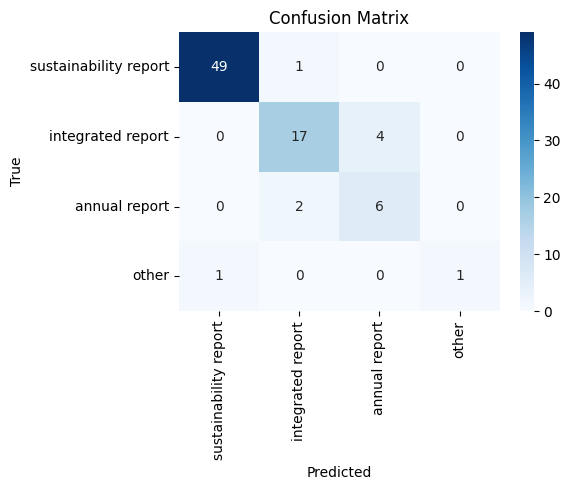

In [13]:
import pandas as pd

# ==== 1. Set file paths ====

human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "results/pipeline9-mini-4-1.csv"

# ==== 2. Read files ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. Normalize column names, ensure filename and report_type exist ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. Merge two tables ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")
df_merged = df_merged.drop_duplicates(subset="file_name", keep="first")

# ==== 6. Compare two classification results ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. Calculate accuracy ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy: {accuracy:.2%}")

# ==== 8. Export comparison results (optional) ====
import re

def clean_illegal_excel_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

# Clean illegal characters
df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)

# Export again
# df_merged_cleaned.to_excel("pipeline_eval/7/classification_comparison.xlsx", index=False)
print("✅ Saved to classification_comparison.xlsx")
# df_merged.to_excel("pipeline_eval/7/classification_comparison.xlsx", index=False)
# print("saved to classification_comparison_result.xlsx")

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === Only keep non-empty comparison items (to prevent null values from affecting) ===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === Print classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # Set to True to return dict
)
print("📊 detailed \n")
print(report)

# === Visualize confusion matrix (optional) ===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

 Final Comparison of name

In [14]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast

df_pred = pd.read_csv("results/pipeline9-mini-4-1.csv")              
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv") 

# Standardize/strip
df_pred["filename"] = df_pred["filename"].astype(str).str.strip()
df_true["filename"] = df_true["pdf_path"].astype(str).str.strip()
df_pred["company_name"] = df_pred["company_name"].astype(str)  # Prevent NaN -> float
df_pred["other_names"] = df_pred.get("other_names", "").fillna("").astype(str)
df_true["name_2"] = df_true["name_2"].astype(str)

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: Utility functions ===
SUFFIXES = [
    " company"," companies"," corporation"," incorporated"," corp"," llc"," ltd"," inc",
    " oyj"," intl"," sa"," lp"," spa"," sanv"," nv"," plc"," nvsa"," ptd",
    " int"," international","limited","group"," holdings"," co"
]
STOPWORDS = {"group","holdings","company","limited","corporation","inc","co","plc","corp","ltd","llc","sa","nv","oyj","spa","intl","int"}

def safe_str(x):
    return "" if x is None or (isinstance(x, float) and pd.isna(x)) else str(x)

def _clean_name(name: str) -> str:
    s = safe_str(name).lower()
    s = re.sub(r"\([^()]*\)", "", s)           # Remove content in parentheses
    s = re.sub(r"[^\w\d\s]", "", s)            # Remove punctuation
    for suf in SUFFIXES:
        s = s.replace(suf, "")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def fuzzy_ratio(a, b):
    return SequenceMatcher(None, _clean_name(a), _clean_name(b)).ratio()

def split_other_names(raw):
    text = safe_str(raw).strip()
    if not text:
        return []
    # JSON list string
    if text.startswith("["):
        try:
            lst = ast.literal_eval(text)
            return [safe_str(x).strip() for x in lst if safe_str(x).strip()]
        except Exception:
            pass
    # Common delimiters
    parts = re.split(r"[;,\n|/]+", text)
    return [p.strip() for p in parts if p.strip()]

def word_overlap(a, b):
    wa = {w for w in re.findall(r"\b\w+\b", safe_str(a).lower()) if w not in STOPWORDS and len(w) > 2}
    wb = {w for w in re.findall(r"\b\w+\b", safe_str(b).lower()) if w not in STOPWORDS and len(w) > 2}
    return len(wa & wb) > 0

def substr_match(a, b):
    aa = _clean_name(a).replace(" ", "")
    bb = _clean_name(b).replace(" ", "")
    return (aa and bb) and (aa in bb or bb in aa)

def acronym(name):
    words = [w for w in re.findall(r"\b\w+\b", safe_str(name).upper()) if w.lower() not in STOPWORDS and len(w) > 2]
    return "".join(w[0] for w in words)

def acronym_match(a, b):
    ac = acronym(a)
    bc = acronym(b)
    return bool(ac) and ac == bc

# === Step 3: Main matching logic (main name/alias + multiple fallbacks) ===
STRICT = 0.85  # Strict threshold: fuzzy >= 0.85

def get_best_match(row):
    name_true = safe_str(row["name_2"])
    name_main = safe_str(row["company_name"])
    best_score = fuzzy_ratio(name_main, name_true)
    matched_by = "company_name" if best_score >= STRICT else "no_match"

    # Try alias first (take highest score)
    cand_alias = split_other_names(row.get("other_names", ""))
    for alias in cand_alias:
        score = fuzzy_ratio(alias, name_true)
        if score > best_score:
            best_score = score
            matched_by = f"other_names({alias})" if score >= STRICT else "no_match"

    is_correct = best_score >= STRICT

    # === Fallback: If strict does not pass threshold, try word overlap / substring / acronym ===
    if not is_correct:
        if word_overlap(name_main, name_true):
            is_correct = True
            matched_by = "fallback_word_overlap"
        elif any(word_overlap(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_word_overlap_from_alias"
        elif substr_match(name_main, name_true) or any(substr_match(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_substring"
        elif acronym_match(name_main, name_true) or any(acronym_match(a, name_true) for a in cand_alias):
            is_correct = True
            matched_by = "fallback_acronym"

    return pd.Series({
        "fuzzy_score": best_score,
        "is_correct": bool(is_correct),
        "matched_by": matched_by
    })

# === Step 4: Apply matching function ===
df_merged[["fuzzy_score", "is_correct", "matched_by"]] = df_merged.apply(get_best_match, axis=1)

# === Step 5: Output evaluation table & accuracy ===
df_eval = df_merged[["filename", "company_name", "other_names", "name_2", "fuzzy_score", "is_correct", "matched_by"]]
# df_eval.to_csv("pipeline_eval/7/company_name2.csv", index=False)

accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (alias + fallbacks): {accuracy:.2%}")
print("📄 Saved:", "eval/company_name_eval_with_alias_and_fallback.csv")

✅ Company name extraction accuracy (alias + fallbacks): 97.55%
📄 Saved: eval/company_name_eval_with_alias_and_fallback.csv


Python Library for name Comparison

In [15]:
import pandas as pd
import re, ast
from name_matching.name_matcher import NameMatcher

pred = pd.read_csv("results/pipeline9-mini-4-1.csv")              
true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  #

pred["filename"] = pred["filename"].astype(str).str.strip()
true["filename"] = true["pdf_path"].astype(str).str.strip()

df = pred.merge(true, on="filename", how="inner")
# ===== 2) Build master library (teacher's standard names) =====
master = (
    df[["name_2"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"name_2": "Company name"})
    .reset_index(drop=True)
)

# ===== 3) Expand candidates (company_name + other_names) =====
def split_other_names(raw):
    """Support JSON list string or separated by semicolon/comma/newline/vertical bar/slash"""
    if pd.isna(raw): 
        return []
    s = str(raw).strip()
    if not s:
        return []
    if s.startswith("["):
        try:
            lst = ast.literal_eval(s)
            return [x.strip() for x in lst if isinstance(x, str) and x.strip()]
        except Exception:
            pass
    parts = re.split(r"[;,\n|/]+", s)
    return [p.strip() for p in parts if p.strip()]

rows = []
for _, r in df.iterrows():
    cands = [str(r.get("company_name", "")).strip()]
    cands += split_other_names(r.get("other_names", ""))
    for c in cands:
        if c:
            rows.append({"filename": r["filename"], "candidate": c})
cand_df = pd.DataFrame(rows).drop_duplicates()

# If some files have no candidates, add an empty placeholder (to avoid losing join later)
if cand_df.empty:
    raise ValueError("No candidates found. Check columns: company_name / other_names.")

# ===== 4) Initialize name_matching and load master library =====
matcher = NameMatcher(
    number_of_matches=1,   # Only take the best hit per candidate
    legal_suffixes=True,   # Automatically handle suffixes like Inc/LLC/Group
    common_words=False,    # Do not filter common words (you can also try True)
    top_n=50,              # Candidate pool size
    verbose=False
)

# You can combine multiple distance metrics; recommended to try the group below (from official example)
matcher.set_distance_metrics(['bag', 'typo', 'refined_soundex'])

matcher.load_and_process_master_data(
    column='Company name',
    df_matching_data=master,
    transform=True
)

# ===== 5) Perform matching =====
matches = matcher.match_names(
    to_be_matched=cand_df,
    column_matching='candidate'
)
# matches contains: match_name (hit name_2), match_index, score(0-100)

cand_scored = cand_df.join(matches)

# ===== 6) Select the best hit for "each file" (highest score) =====
best_per_file = (
    cand_scored
    .sort_values(["filename", "score"], ascending=[True, False])
    .drop_duplicates("filename")
    .rename(columns={"match_name": "matched_name_2", "score": "nm_score"})
)

# ===== 7) Merge back to original df, evaluate =====
eval_df = df.merge(best_per_file[["filename", "candidate", "matched_name_2", "nm_score"]],
                   on="filename", how="left")

# Determine whether it matches: strict threshold (adjustable)
STRICT = 85
eval_df["is_correct"] = (eval_df["nm_score"].fillna(0) >= STRICT)

# Mark match source: main name or alias
def matched_by(row):
    cname = str(row.get("company_name", "")).strip()
    cand  = str(row.get("candidate", "")).strip()
    if not cand:
        return "no_match"
    return "company_name" if cand == cname else "other_names"

eval_df["matched_by"] = eval_df.apply(matched_by, axis=1)

# ===== 8) Output results =====
out_cols = [
    "filename", "company_name", "other_names", "name_2",
    "candidate", "matched_name_2", "nm_score", "is_correct", "matched_by"
]
# eval_df[out_cols].to_csv("eval/company_name_eval_name_matching_only.csv", index=False)

acc = eval_df["is_correct"].mean()
print(f"✅ Accuracy (name_matching only, threshold={STRICT}): {acc:.2%}")
print("📄 Saved: eval/company_name_eval_name_matching_only.csv")

✅ Accuracy (name_matching only, threshold=85): 95.10%
📄 Saved: eval/company_name_eval_name_matching_only.csv
